<a href="https://colab.research.google.com/github/netorai/LEI/blob/main/VAE_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LOAD DATA

In [ ]:
def load_data(i):
    if i == 1:
        #mount Google Drive
        from google.colab import drive
        drive.mount('/content/gdrive', force_remount=True)
        #create results dir
        %cd /content/gdrive/My\ Drive/Colab\ Notebooks/PLX\ Morphology
    #%cd gdrive/My\ Drive/Colab\ Notebooks/PLX\ Morphology/Datasets
    #load images and labels
    images = np.load('Datasets/' + IMG_ARRAY_NAME)
    labels = np.load('Datasets/' + IMG_LABEL_NAME)
    os.makedirs('Experiments/'+RUN_TIME, exist_ok=True)
    return images, labels

NORMALIZE

In [ ]:
def prepare_data(array_of_images):
    array_of_images = array_of_images.astype('float32')/255.
    return array_of_images

RANDOM IMAGE SHUFFLE

In [ ]:
def shuffle_data(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y

SPLIT INTO TRAIN AND TEST SETS

In [12]:
def split_data(X, y, perc=20):
    train_idx = np.arange(0, int(len(X)*(100-perc)/100))
    test_idx = np.arange(int(len(X)*(100-perc)/100+1), len(X))
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]
    return X_train, y_train, X_test, y_test

In [15]:
X_train, y_train, X_test, y_test = split_data(img_64, label_64)

AttributeError: ignored

CHECK HOW BALANCE THE DATA IS

In [ ]:
def check_data_balance(y, y_ori_size, title=None):
    (unique, counts) = np.unique(y, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    print(50*'*')
    if title is not None:
        print(title)
    print("Total of", round(len(y)/y_ori_size*100, 2), "% of original data.")
    print("Classes:", CLASSES)
    print("Dataset Balance:\n", frequencies)
    print(50*'*')

ANALYZE DATASETS

In [ ]:
def analyze_data(img_list, img_labels, title):
    print(50*'*')
    print("Images (X) shape:", img_list.shape)
    print("Images (y) shape:", img_labels.shape)
    visualize_data(img_list, img_labels, title)
    print(50*'*')

MATPLOTLIB IT

In [7]:
def visualize_data(img_list, img_labels, title):
    #a set of 9 figures
    fig = plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(tf.squeeze(img_list[i]))
        plt.xlabel(CLASSES[img_labels[i]])
    fig.suptitle(title)
    #plt.show()

NameError: ignored

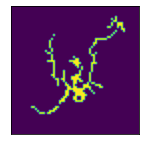

In [10]:
visualize_data(img_64, label_64, 'ok')

# **VAE**

In [11]:
#Create a sampling function that uses (z_mean, z_log_sigma) to sample z (using log to ensure positivity of std dev)
#Draws samples from a standard normal and scales the samples with standard 
#deviation of the variational distribution and shifts them by the mean
def sampling(args):
    z_mean, z_log_sigma = args
    #removing the log
    z_sigma = tf.keras.backend.exp(z_log_sigma)
    #a gaussian tensor
    epsilon = tf.keras.backend.random_normal(shape=tf.keras.backend.shape(z_mean), mean=0., stddev=.1)
    return z_mean + z_sigma * epsilon

In [20]:
sampled = sampling(X_train)

ValueError: ignored

FIRST ENCODER

In [53]:
def create_vae_encoder(IMG_HEIGHT, IMG_WIDTH):
    LATENT_DIM = 64 * 64
    #encoder
    input_image = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    #Arch v2
    encoded = tf.keras.layers.Conv2D(16, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(input_image)
    encoded = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(encoded)
    #encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.Conv2D(32, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(encoded)
    encoded = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(encoded)
    #encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.Conv2D(64, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(encoded)
    encoded = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(encoded)
    #encoded = tf.keras.layers.BatchNormalization()(encoded)
    encoded = tf.keras.layers.Conv2D(128, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(encoded)
    encoded = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(encoded)
    encoded = tf.keras.layers.Conv2D(256, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(encoded)
    encoded = tf.keras.layers.Conv2D(512, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(encoded)
    encoded = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(encoded)
    encoded = tf.keras.layers.Conv2D(512, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(encoded)
    encoded = tf.keras.layers.Conv2D(1024, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(encoded)
    encoded = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(encoded)
    encoded = tf.keras.layers.Flatten()(encoded)
    encoded = tf.keras.layers.Dense(256, activation=tf.keras.layers.ReLU())(encoded)
    encoded = tf.keras.layers.Dense(32, activation=tf.keras.layers.ReLU())(encoded)
    '''
    #Arch v1
    encoded = tf.keras.layers.Conv2D(32, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(input_image)
    encoded = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(encoded)
    encoded = tf.keras.layers.Conv2D(64, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(encoded)
    encoded = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(encoded)
    if img_height == 128:
        encoded = tf.keras.layers.Conv2D(64, (2,2), activation=tf.keras.layers.ReLU(), padding='same')(encoded)
        encoded = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(encoded)
    encoded = tf.keras.layers.Flatten()(encoded)
    encoded = tf.keras.layers.Dense(32, activation=tf.keras.layers.ReLU())(encoded)
    '''
    z_mean = tf.keras.layers.Dense(LATENT_DIM, name='z_mean')(encoded) 
    z_log_sigma = tf.keras.layers.Dense(LATENT_DIM, name='z_log_sigma')(encoded) 
    #using the sampling function within a lambda layer to obtain our sampled z
    z = tf.keras.layers.Lambda(sampling, name='z')([z_mean, z_log_sigma]) 
    #the model
    encoder = tf.keras.Model(inputs=input_image, outputs=[z_mean, z_log_sigma, z], name='encoder')
    #print("\n############### ENCODER #################")
    #encoder.summary()
    return encoder

THEN, DECODER

In [54]:
def create_vae_decoder(img_height):
    #decoder
    LATENT_DIM = 64 * 64
    input_latent = tf.keras.layers.Input(shape=(LATENT_DIM,)) 
    #Arch v2
    decoded = tf.keras.layers.Dense(4 * 4 * 16, activation=tf.keras.layers.LeakyReLU(alpha=0.1))(input_latent) #check the encoder shape on the last conv layer
    decoded = tf.keras.layers.Reshape((4, 4, 16))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(1024, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(512, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(256, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(128, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(64, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(32, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    '''
    #Arch v1
    decoded = tf.keras.layers.Dense(4 * 4 * 16, activation=tf.keras.layers.LeakyReLU(alpha=0.1))(input_latent) #check the encoder shape on the last conv layer
    decoded = tf.keras.layers.Reshape((4, 4, 16))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(16, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(32, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(32, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    decoded = tf.keras.layers.Conv2DTranspose(64, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    if img_height == 128:
        decoded = tf.keras.layers.Conv2DTranspose(128, (2,2), activation=tf.keras.layers.ReLU(), padding='same', strides=(2,2))(decoded)
    '''
    decoded = tf.keras.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(decoded)
    #the model
    decoder = tf.keras.Model(inputs=input_latent, outputs=decoded, name='decoder')
    #print("\n############### DECODER #################")
    #decoder.summary()  
    return decoder

NOW, THE VAE

In [34]:
def create_vae(encoder, decoder):
    IMG_HEIGHT = 64
    IMG_WIDTH = 64
    input_image = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    z_mean, z_log_sigma, z = encoder(input_image)
    z_decoded = decoder(z)
    vae = tf.keras.Model(inputs=input_image, outputs=z_decoded, name='vae')
    print("\n############### VAE #################")
    vae.summary()  
    #Two loss functions
    #rc_loss - a reconstruction loss forcing the decoded samples to match the initial input (higher loss)
    #kl_loss - a KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term
    #helps learning well-formed latent spaces and reducing overfitting to the training data
    rc_loss = tf.keras.backend.sum(tf.keras.backend.binary_crossentropy(tf.keras.backend.batch_flatten(input_image), tf.keras.backend.batch_flatten(z_decoded)))
    kl_loss = -0.5 * tf.keras.backend.sum(1 + z_log_sigma - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_sigma), axis=-1)
    vae_loss = tf.keras.backend.mean(rc_loss + kl_loss)
    vae.add_loss(vae_loss)    
    return vae, z_mean, z_log_sigma

In [55]:
vae, z_mean, z_log_sigma = create_vae(create_vae_encoder(64,64),create_vae_decoder(64))


############### VAE #################
Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 4096), (None, 409 4387664   
_________________________________________________________________
decoder (Functional)         (None, 256, 256, 1)       3910145   
Total params: 8,297,809
Trainable params: 8,297,809
Non-trainable params: 0
_________________________________________________________________


In [59]:
vae.compile()
vae.evaluate(X_train)

ValueError: ignored

# **TESTE**

In [2]:
import numpy as np
#Import images with 64x64 resolution
img_64 = np.load('./array_of_images_64_64_20210316.npy')
label_64= np.load('./array_of_labels_64_64_20210316.npy')

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def analyze_data(img_list, img_labels, title):
    print(50*'*')
    print("Images (X) shape:", img_list.shape)
    print("Images (y) shape:", img_labels.shape)
    visualize_data(img_list, img_labels, title)
    print(50*'*')

#Matplotlib it
def visualize_data(img_list, img_labels, title):
    #a set of 9 figures
    fig = plt.figure(figsize=(8,8))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(tf.squeeze(img_list[i]))

**************************************************
Images (X) shape: (1320, 64, 64, 1)
Images (y) shape: (1320,)
**************************************************


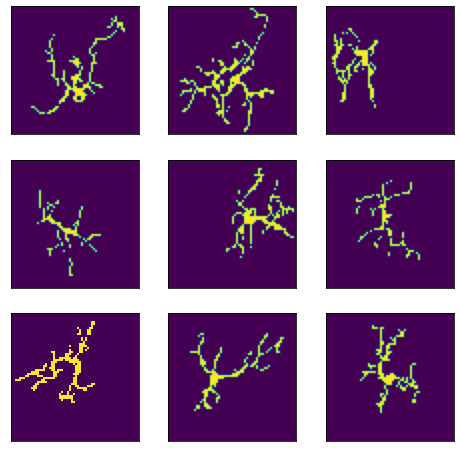

In [6]:
#Analyzing 64x64 images data
analyze_data(img_64, label_64, 'teste')